# Preamble
The codeblocks below are there to important the right packages, provide some helper functions, and hardcode a number of often used values. If you find yourself needed to make adjustments to these codeblocks to make the code work, please let us know as this most likely means that something has gone wrong in our implementation.

In [ ]:
%matplotlib notebook

import torch
import numpy as np

from tqdm import tqdm

import torch.distributions as D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

In [ ]:
def reset_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)

# Number of samples used for MC integration
N = 10000

In [ ]:
class AnimationPlotter():
  def __init__(self, potential):
    self.buffer = []
    self.xs = torch.linspace(-5, 5, 100)
    self.potential = potential
    self.pots = potential(self.xs)

    self.internal_energies = []
    self.entropies = []
    self.free_energies = []

  def add_to_buffer(self, p, samples):
    self.buffer.append(torch.exp(p.log_prob(self.xs)).detach())
    self.internal_energies.append(U(samples, p, self.potential).mean().detach().clone())
    self.entropies.append(S(samples, p).mean().detach().clone())
    self.free_energies.append(F(samples, p, self.potential).mean().detach().clone())

  def animate(self):
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))
      ax[0].plot(self.xs, self.pots, label="Potential Energy")
      l, = ax[0].plot([],[], label="Probability distribution")
      lU, = ax[1].plot([],[], label="Internal Energy")
      lS, = ax[1].plot([],[], label="Entropy")
      lF, = ax[1].plot([],[], label="Free Energy")
      ax[0].set_xlim(-5, 5)
      ax[0].set_ylim(-1, 4)
      ax[1].set_xlim(0, len(self.free_energies)-1)
      ax[1].set_ylim(-2, 5)
      ax[1].legend()
      ax[0].legend()

      def ani(i):
          l.set_data(self.xs, self.buffer[i])

          xs = torch.range(0, len(self.free_energies[:(i+1)])-1)
          lU.set_data(xs, self.internal_energies[:(i+1)])#, label="Internal Energy")
          lS.set_data(xs, self.entropies[:(i+1)])#, label="Entropy")
          lF.set_data(xs, self.free_energies[:(i+1)])#, label="Free Energy")

      ani = animation.FuncAnimation(fig, ani, frames=len(self.buffer), interval=50)

      from IPython.display import HTML
      return HTML(ani.to_jshtml())

# Administrative Information
Again, please note that none of the tasks set are supposed to be extremely challenging and if you do run into any problems, chances are high that this is due to unclarity on our side. As such, if you are stuck on a task for a longer time, do please reach out to lars@aims.ac.za

The notebooks are roughly structured as follows:
- Coding tasks and questions are mixed together and are highlighted by the keyword: "**Task**".
- Depending on what the task is acking for, the task will be followed by either a codeblock containing some pre-writen helper code and a `#Todo` flag after which you can add your implementation, or a markdown block containing the keyword "*Answer:*" for you to provide your answer.
- Some tasks are followed by a "**Hint:**" which will contain some extra instructions for the coding implementations, or it might point you towards the right answer to a question.
- At the end of each notebook we will have a short section with additional challenging extensions that you could choose to work on if you found a topic interesting. Please note that you are not required to do these extensions. Solving one or more of the extensions does **not** by definition result in a higher grade for the course.

Lastly, to help us in improving the coding assignments in the following weeks, please fill in the anonymous feedback [form](https://forms.gle/vVBXm7nhW94yMkHr8) (you can do this for every assigment, just make sure to pick the correct day you just finished in the shee). We highly appreciate your feedback, positive and negative!

# Section 1: Minimal Free-Energy
Yesterday we studied how internal energy, entropy and free-energy change as a function of the hamiltonian and probability distribution used. Our approach here was quite unstructured, we simply tried different potentials and different distributions and looked at what happened. Today we are going to be a bit more rigorous and try to find a probability distribution that minimizes the free-energy for a given hamiltonian. Fort his purpose we will first consider only probability distributions of the Gaussian family, but in the next section we will see how we can also define an arbitrary distribution!



## Section 1.1: Recap yesterday

First, we will recap some of the concepts we looked at yesterday and make some adjustments to our code from yesterday to make it more suitable for the tasks today. First, let's restate the definitions of internal energy, entropy and free-energy:
**Internal Energy / Expected Energy**
$$
{U}[p] =  \int dx p(x) {H}(x)
$$

**Entropy**
$$
S[p] =  - \int dx p(x) \log p(x)
$$

**Free-Energy**
$$
{F}[p] = U[p] - T {S}[p]
$$

For the first part of the assignent we can ignore the temperature and set $T = 1$. *Please note that we had an error in the sign of the entropy yesterday, this is now resolved.*

> **Task**: The first task is to make a small adjustment from your code yesterday. Instead of passing in a probability distribution p, we will now give U, S and F a number of samples (sampled from p, or some other distribution). Everything else should remain the same.

**Hint:** Please check that if you copy in your code of yesterday that you fix the sign of the entropy if you worked with an older version of the file yesterday.

In [ ]:
def U(p, H):
  samples = p.sample((N,))
  U=H(samples).mean()
  # TODO
  return U

def S(p):
  samples = p.sample((N,))
  S=-torch.log(p.log_prob(samples).exp()).mean()
  # TODO
  return S

def F(p, H):
  u=U(p, H)
  s=S(p)
  F=u-s
  return F

In [ ]:
def U(samples, p, H):
  U=H(samples).mean()
  return U

def S(samples, p):
  S=-torch.log(p.log_prob(samples).exp()).mean()
  # TODO
  return S

def F(samples, p, H):
   u=U(samples, p, H)
   s=S(samples, p)
   F=u-s
  # TODO
   return F

**Checkpoint**: We will need the code you have created above throughout the rest of the practical. Please run the code below to see if your implementation is correct. You should get the following output:

```
0.8665626049041748
0.6931473016738892
0.17341530323028564
```

In [ ]:
reset_seeds()

double_well_potential = lambda x: -x**2 + x**4 + 1
uniform_distribution = D.Uniform(-1, 1)
samples = uniform_distribution.sample((N,))

internal_energy = U(samples, uniform_distribution, double_well_potential)
entropy = S(samples, uniform_distribution)
free_energy = F(samples, uniform_distribution, double_well_potential)

print(internal_energy.item())
print(entropy.item())
print(free_energy.item())

0.8659842610359192
0.6931473016738892
0.17283695936203003


## Section 1.2: Optimizing Free Energy
As mentioned above, today we will focus on finding probability distributions that minimize the free-energy for a given Hamiltonian. For this purpose we will first consider the harmonic potential and a Gaussian distribution.

Formally, given a Hamiltonian $H$ we are going to try to find optimal $\mu^*$ and $\sigma^*$ such that
$$
\arg\min_{\mu, \sigma} F(\mathcal{N}(\mu, \sigma), H).
$$

We will be doing this using iterative gradient descent using the pytorch framework. We will start with a random initialization $\mu_0$ and $\sigma_0$ and iterative apply the gradient update steps:
\begin{align}
  \mu_{t+1} = \mu_t + \eta \cdot \frac{\partial F}{\partial \mu_t}(\mathcal{N}(\mu_t, \sigma_t), H) \\
  \sigma_{t+1} = \sigma_t + \eta \cdot \frac{\partial F}{\partial \sigma_t} (\mathcal{N}(\mu_t, \sigma_t), H)
\end{align}

> **Task**: Implement the missing components in the function `determine_minimal_free_energy_normal()`:
- Given N samples sampled from your current Gaussian distribution, determine the Free-Energy
- Take the gradient of the free-energy with respect to your parameters and apply and update step.

In [ ]:
def harmonic_potential(a, b):
  return lambda x: b * (x - a)**2

In [ ]:
def determine_minimal_free_energy_normal(potential, animation_plotter=None, progress_plotter=None):
  # Initialize the mean and variance of the normal distribution
  mean = torch.tensor(0., requires_grad=True)
  std = torch.tensor(1., requires_grad=True)

  p = D.Normal(mean, std)

  # Set the learning rate
  lr = 0.01

  for _ in tqdm(range(500)):
    # Sample from the distribution
    samples = p.rsample((N,))

    # Calculate the Free-Energy for all samples
    free_energy=F(samples, p, potential)
    #TODO

    # Update the mean
    grad_mean = torch.autograd.grad(free_energy, mean, retain_graph=True)[0]
    mean.data -=lr*grad_mean #TODO

    # # Update the std
    grad_std = torch.autograd.grad(free_energy, std, retain_graph=False)[0]
    std.data -=lr*grad_std #TODO

    if animation_plotter is not None: animation_plotter.add_to_buffer(p, samples)

  return p


**Checkpoint**: Run the code block below to see if your implementation worked correct, the output should be:
```
100%|██████████| 500/500 [00:01<00:00, 464.61it/s]
Normal(loc: 0.999645471572876, scale: 0.7078309655189514)
```

In [ ]:
reset_seeds()

# Set up the potential function
potential = harmonic_potential(1, 1.)

# Set up the plotters
p = determine_minimal_free_energy_normal(potential)
print()
print(p)

100%|██████████| 500/500 [00:00<00:00, 811.84it/s]


Normal(loc: 0.999645471572876, scale: 0.7078310251235962)


> **Task:** Do you know why we use rsample instead of sample to obtain samples form out distribution $\mathcal{N}(\mu_t, \sigma_t)$? If, so, where in machine learning have you seen it before? If not, have you heard about the reparametrisation trick? (This is an open question, not knowing the answer is completely fine. We will cover this briefly next week. *No marks will be deducated for answering this question with; "No."*)

*Answer:*
No


## Section 1.4: Experiments with Harmonic Potential
Now that we have implemented the optimization procedure we can investigate how $\mu$ and $\sigma$ will change based on the parameters $a$ and $b$ of our harmonig potential.

> **Task**: Try different values for a and b with the Harmonic Potential. Does the Entropy always go up? Is this a suprising result?

**Hint:** To get a better understanding of how the distribution changes, we have implemented a plotting class. The codeblock below shows how it can be used.

*Answer:*

The Entropy does not always go up. when both $a\ $ and $\ b$ are both away from 1, the Entropy decrease and  get closer to the internal energy and the free-energy tend to zero. Whereas the Entropy increase when $a$ and $b$ is closer to 1.



In [18]:
# Set up the potential function
potential = harmonic_potential(1, .1)

# Set up the plotters
plotter = AnimationPlotter(potential)

p = determine_minimal_free_energy_normal(potential, animation_plotter=plotter)

plotter.animate()

Output hidden; open in https://colab.research.google.com to view.

In [20]:
#@title experiment (interactif) {run: "auto"}
## a and b values
a=6 #@param {type:"slider", min:1, max:10, step:1}
b=2 #@param {type:"slider", min:1, max:10, step:1}
# potential function
potential = harmonic_potential(a, b)

# Set up the plotters
plotter = AnimationPlotter(potential)

p = determine_minimal_free_energy_normal(potential, animation_plotter=plotter)

plotter.animate()

Output hidden; open in https://colab.research.google.com to view.

## Section 1.5: Boltzmann distribution
So far we have only considered finding the Gaussian distribution with minimal free-energy for the Harmonic potential, but, as we discussed yesterday, infinitely many different potential function can be defined. One such potential is the double well potential that we also used yesterday.

> **Task:** Find the Gaussian distribution with minimal free-energy for the double-well potential.

In [22]:
def double_well_potential():
  return lambda x: -x**2 + x**4

In [23]:
p=determine_minimal_free_energy_normal(double_well_potential(), animation_plotter=None, progress_plotter=None)
print(f'Gaussian distribution with minimal free-energy for double well potential is given by: ')
print(p)
# TODO


100%|██████████| 500/500 [00:00<00:00, 725.47it/s]

Gaussian distribution with minimal free-energy for double well potential is given by: 
Normal(loc: 6.639398634433746e-05, scale: 0.6208270788192749)


> **Task:** How does the probability distribution that we find for the harmonic potential relate to the Boltzmann Distribution that we derived during class today? What about when we use the DoubleWell potential?

**Hint:** Look at the definition of the Gaussian distribution
$$
\begin{align}
    p(x)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{1}{2\sigma^2}(x-\mu)^2\right),
\end{align}
$$
and the Boltzmann distribution
$$
\begin{align}
    p(x)=\frac{1}{Z}\exp\left(-\beta H(x)\right).
\end{align}
$$


*Answer:*
the probability distribution that we find, is a particular case of the Boltzmann distribution with,

-   harmonic potential given by : $H(x)=(x-\mu)^{2},\quad \ a=\mu\ \ and\ \ b=1$
- $\beta=\frac{1}{2\sigma^{2}}$
-  $Z=\sqrt{2\pi}\sigma$

When we use Double well potential, we have the following relationship,


-   harmonic potential given by : $H(x)=(x-\mu)^{2}\Longrightarrow -x^{2}+x^{4}=x^{2}-2\mu x +\mu^{2}⇒ x^{4}-2x^{2}+2\mu x -\mu^{2}=0$
- $\beta=\frac{1}{2\sigma^{2}}$
-  $Z=\sqrt{2\pi}\sigma$


## Section 2: Boltzmann Distribution
As we saw in the previous section, if we parameterise the Gaussian distribution with $\mu$ and $\sigma$, we can find a minimal free-energy distribution. However, while in the case of a harmonic-potential the Gaussian distribution suffices, we require a more flexible family of distributions for other hamiltonians.

The Boltzmann distribution is that flexible family of distributions. It describes the probability distribution with the leat amount of information assumed. The only requirement/constraint that we have for it is that given a Hamiltonian $H$, we want the Internal Energy under our optimized distribution to be equal to a predefined value $E$. Otherwise, we are free to chose any distribution that minimizes the Free-Energy.

> **Task:** During the lecture Max explained that the Boltzmann distribution is a Max-Entropy distribution. However, we are now talking about minimizing the Free-Energy. Why is this not a problem? How is this different from the Free-Energy optimization we did in the previous section?






## Section 2.1: Deriving the Boltzmann Distribution
We can derive the Boltzmann distribution by solving a constrained optimization problem using Lagrange multipliers. Following the derivation in section 2.1 of the lecture notes, we are going to skip a head to equation 2.22. At this point we have solved the KKT conditions to obtain the Boltzmann distribution
$$
p^{eq}(x) = \frac{1}{\exp(\lambda-1)}\exp(-\beta H(x))
$$
and with $\bar\lambda = \lambda - 1$ have found the normalization constant
\begin{align}
    \bar\lambda^* = \log Z(\beta) = \log\int dx~\exp(-\beta H(x)).
\end{align}

> **Task:** Implement the unnormalised version of the Boltzmann distribution in the code block below.

In [24]:
def unnormalised_boltzmann_distribution(potential, beta, x):
  return  torch.exp(-beta*potential(x)) # TODO

To assist in the next steps, below we have implemented so short helper functions to determine the normalization constant, define the normalised Boltzmann distribution and to calculate expectations under the Boltzmann distribution.

In [25]:
def normalizing_constant(potential, beta):
  # To get the normalization constant we need to
  xs = torch.linspace(-5, 5, 10000)
  unn = unnormalised_boltzmann_distribution(potential, beta, xs)
  return unn.mean() * 10

def boltzmann_distribution(potential, beta, x):
  return (1/normalizing_constant(potential, beta)) * unnormalised_boltzmann_distribution(potential, beta, x)

def expectation(potential, beta, function):
  xs = torch.linspace(-5, 5, 1000)
  expectation = (function(xs) * boltzmann_distribution(potential, beta, xs)).mean()
  return expectation

To find the the value of $\beta$ that minimizes the free-energy for a given internal energy we are going to use a iterative gradient descent procedure as suggested in the lecture notes. For this purpose we use the gradient update step:
\begin{align}
  \beta_{t+1} &= \beta_t + \eta \cdot \frac{\partial L_D}{\partial \beta} \\
              &= \beta_t + \eta \cdot (E - \mathbb{E}_{p^{eq}(\beta_t)}[H])
\end{align}

> **Task:** Implement the iterative gradient descent procedure below.

In [26]:
def determine_optimal_beta(potential, E):
  beta = torch.tensor(0.)

  # Set the learning rate
  lr = 0.1

  for _ in tqdm(range(10000)):
    # Calculate Gradient eq. (2.22)
    internal_energy =  expectation(potential, beta, potential) # TODO
    grad =E-internal_energy # TODO

    # Update beta
    beta =beta-lr*grad # TODO

    # print(beta, internal_energy)
  return beta

**Checkpoint:** The codeblock below should give the following output:
```
100%|██████████| 10000/10000 [00:11<00:00, 863.85it/s]
tensor(0.9452)
```

In [29]:
reset_seeds()

E = 0.
beta = determine_optimal_beta(double_well_potential(), E)
print()
print(beta)

100%|██████████| 10000/10000 [00:05<00:00, 1991.18it/s]


tensor(0.9452)


During the lecture we discussed how in physics we interpret $\beta$ as the inverse temperature:
$$
  \beta = \frac{1}{T}.
$$

While it is important to realise that it is actually the internal energy $E$ that defines the temperature $T$, in most cases in machine learning it is acceptable to argue the other way around. For a given $T$ and hamiltonian $H$, we can derive the internal energy, entropy and free-energy under the Boltzmann distribution.

> Task: Plot the internal energy, entropy and free-energy as a function of $T$ for the double well potential. Do you observe any patterns?

In [46]:
# temperature
T=torch.linspace(0.1,200,300)

#define the log of the Boltzmann distribution to compute the Entropy
def log_Boltzmann_dist (x):
  return torch.log(boltzmann_distribution(potential, beta, x))

internal_energy=[]
entropy=[]
free_energy=[]
for t in T:
  # internal energy
  u=expectation(double_well_potential(), 1/t, double_well_potential())
  internal_energy.append(u)
  ## Entropy
  s=-expectation(double_well_potential(), 1/t, log_Boltzmann_dist)
  entropy.append(s)
  #free_energy = internal_energy-entropy
  free_energy.append(u-t*s)
# Todo


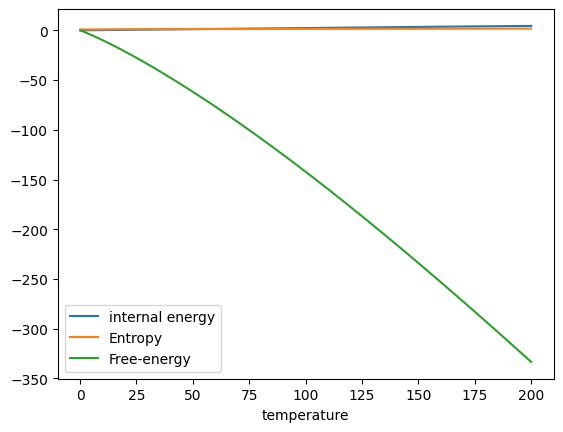

In [47]:
%matplotlib inline
plt.plot(T,torch.tensor(internal_energy),label="internal energy")
plt.plot(T,torch.tensor(entropy),label="Entropy")
plt.plot(T,torch.tensor(free_energy),label="Free-energy")
plt.legend()
plt.xlabel('temperature')
plt.show()


*Answer:*

The free energy decrease as the temperature increase.
the internal energy increase slighly go away from zero whereas the entropy remain constant.


## Extensions
If you want to explore the topics discussed in this assignment further, consider looking at one of the below variations of the assigment:
- We have so far considered two different potential functions, the harmonic and the double well potentials. Try to think of another potential and see how the boltzmann distribution changes with $T$.